#### Бурнышев Павел Иванович
##### pavel.burnysheff@yandex.ru

# Singular Spectrum Analysis (SSA) - problem 20
В крупную сеть гипермаркетов ежедневно выполняются поставки различных товаров. Требуется, использую временную историю спроса бананов за один год Goods, построить прогноз спроса товара на неделю. Для прогнозирования предлагается использовать алгоритм Гусеница, или *SSA (Singular spectrum analysis)*.

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df

import scipy.linalg
import scipy.io
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import plot
from plotly.graph_objs import Scatter, Box
from plotly import tools

plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = scipy.io.loadmat('Data_data.mat')
series = pd.Series(map(lambda x: x[0], data['Data']))

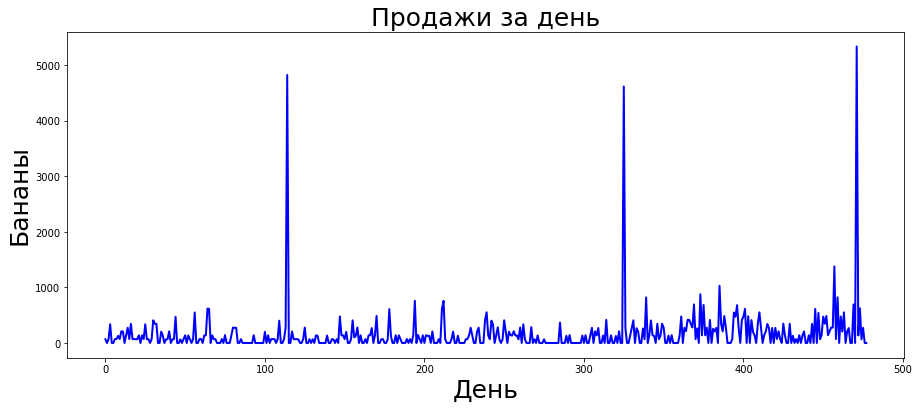

In [4]:
n = np.arange(len(series))
plt.figure(figsize=(15,6))
plt.rcParams['lines.linewidth'] = 2
plt.plot(n, series, color="blue")
plt.xlabel('День', fontsize=25)
plt.ylabel('Бананы', fontsize=25)
plt.title ('Продажи за день', fontsize=25)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24
plt.show()

### Необходимо произвести декомпозицию временного ряда
У нас имеется ряд $\mathcal{X} = (x_1,\ldots,x_N)$ длины $N$. Введем целое число $L\;(1 < L < N)$, называемое длиной окна, и $K = N-L+1$.
Строим матрицу $L\times K$ - траекторную матрицу ряда $X$, она является генкелевой:
$$
X = [X_1:\ldots :X_k] =  \begin{bmatrix}
x_1 & x_2 & x_3 & \dotsb & x_K \\
x_2 & x_3 & x_4 & \dotsb & x_{K+1} \\
x_3 & x_4 & c_3 & \dotsb & x_{K+2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
x_L & x_{L+1} & x_{L+2} & \dotsb & x_N 
\end{bmatrix}  
$$

Введём матрицу $S = XX^T$, выполним её сингулярное разложение:
$$S = U\Lambda V^T.$$

Обозначим собственные числа матрицы $S$ (в невозрастающем порядке) $\lambda_1,\; \lambda_2\ldots\;\lambda_L \geq 0$, и $U_1,\; U_2\;\ldots\;U_L$ - ортонормированную систему собственных векторов матрицы $S$.

Введем обозначения: 
$$
d = rank\; X = max\{i:\;\lambda_i >0\},\;V_i = \dfrac{X^TU_i}{\lambda_i}\;(i = 1,\ldots,d).
$$
В этих обозначениях сингулярное разложение траекторной матрицы $X$ записывается в виде 
$$
X = X_{I_1}+\ldots +X_{I_d},
$$
где матрицы $X_i = \sqrt{\lambda_i}U_iV_i^T$ имеют ранг один и называются *элементарными матрицами*. Набор $\left(\sqrt{\lambda_i}, U_i, V_i\right)$ называется *собственной тройкой* сингулярного разложения. 

Процедура выбора подмножества элементарных матриц $I_1,\ldots,I_d$ которые будут задействованы в восстановлении $X$ называется *группировкой собственных троек*.

In [5]:
def decom(data, time):
    X = np.matrix(scipy.linalg.hankel(data, np.zeros(time))).T[:, :len(data)-time+1]#траекторная матрица
    d = np.linalg.matrix_rank(X)# ранг 
    S = X * X.T
    U, s, V = np.linalg.svd(S, full_matrices=True) # svd разложение S
    U = np.matrix(U)
    s = np.sqrt(s)
    V = np.matrix(V)
    V_ = []
    X_ = []
    for i in range(d):
        V_.append(X.T * U[:,i]/np.sqrt(s[i]))
        X_.append(np.sqrt(s[i])*U[:,i]*V_[i].T)
    return X, U, s, X_ # возвращаем траекторную матрицу, 
                    #собственные числа матрицы
                    # и разложение X по элементарным матрицам

In [6]:
time = 50 # задаем параметр "окна"
X, U, s, X_ = decom(series,time)

Посмотрим на полученные собственные значения:

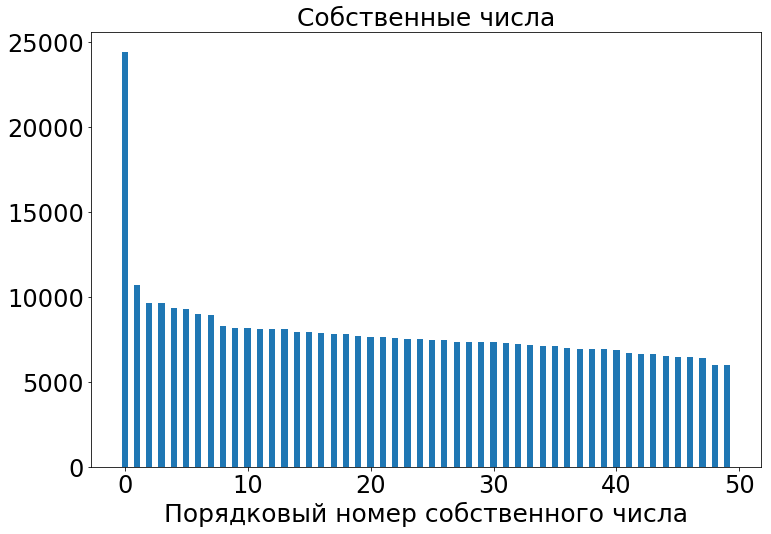

In [8]:
n = np.arange(len(s))
plt.figure(figsize=(12,8))
p1 = plt.bar(n, s, width = 0.5)
plt.xlabel('Порядковый номер собственного числа', fontsize=25)
plt.title ('Собственные числа', fontsize=25)
plt.show()

После группировки собственных троек получаем набор матриц, которые в общем случае не будут ганкелевы, поэтому необходимо произвести процедуру **диагонального усреднения**. 

Пусть матрица $Y$ имеет форму $L\times K,\; L < K$. Во время диагонального усреднения мы переводим матрицу в ряд $(y_1,\ldots,y_N)$, используя формулу 

$$
\widetilde{y_s} = \sum_{(l,k)\in A_s}\dfrac{y_{lk}}{\|A_s\|},
$$
где $A_s = \{(l,k):\; l+k = s+1,\; 1\leq \leq L,\; 1\leq k \leq K\}$.

После приведения к ганкелеву виду всех матриц разложим исходную траекторную матрицу
$$
X = \sum_{k=0}^{m}\widetilde{X_{I_k}}
$$

In [9]:
def henkelization(x):
    x1, x2 = min(x.shape[0],x.shape[1]), max(x.shape[0],x.shape[1])
    result = []
    for i in range(1-x2, x1):
        m = np.eye(x2,k=i,dtype='bool')[::-1][:x1,:]
        mas = np.ma.masked_array(x,mask = 1-m)
        result = result + [mas.sum()/sum(sum(m))]
    return result

## Теперь мы можем аппроксимировать исходный временной ряд, выбирая различное число троек сингулярного разложения:

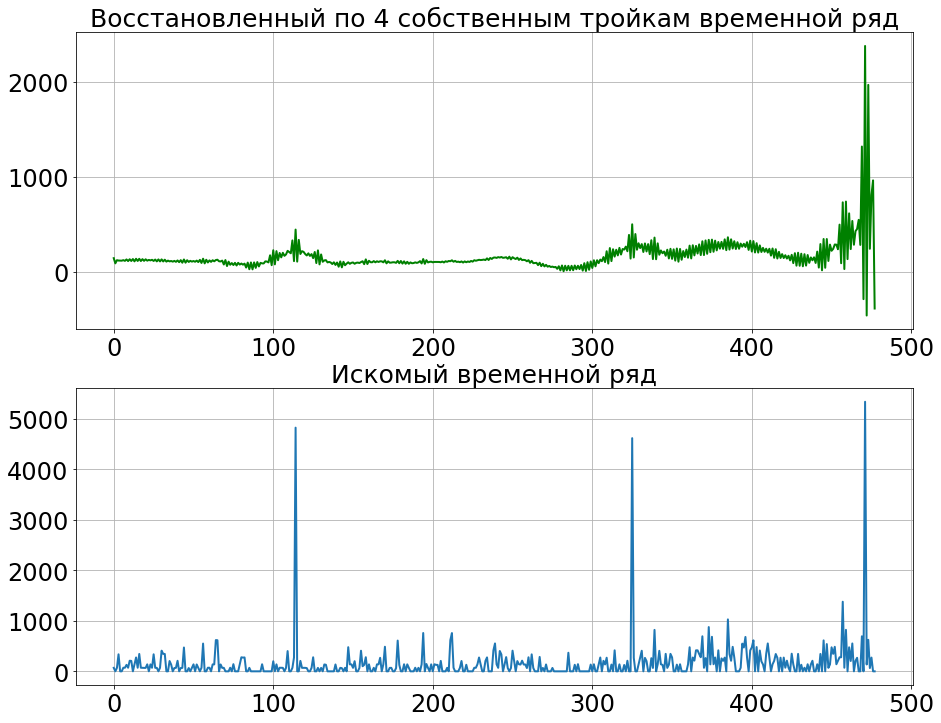

In [10]:
number = 4
re_x = henkelization( sum([X_[i] for i in range(number)]))
real_x = henkelization(X)
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize = (15,12))
ax0.plot(re_x, color = 'green')
ax0.set_title('Восстановленный по {0} собственным тройкам временной ряд'.format(number),fontsize=25)
ax0.grid()
ax1.plot(real_x)
ax1.grid()
ax1.set_title('Искомый временной ряд',fontsize=25)
plt.show()


Реализуем функцию, делающую предсказание значений временного ряда.
Используем рекуррентный метод, согласно ему модель можно описать с помощью линейной реккурентной формулы:
$$
y_{i+d} = \sum_{k=1}^{d}a_ky_{i+d-k},\; 1 \leq i \leq N-d.
$$
Для нахождения коэффициентов $a_k$ используем собственные векторы из $SVD$ разложения. Пусть $U = (u_1,\ldots,u_L)^T,\; U^{\nabla} = (u_1,\ldots,u_{L-1})^T, \pi_i$ - последняя компонента собственного вектора $(\pi_i = U_L)$. В этих обозначениях коэффициенты в реккурентной формуле могут быть вычислены таким образом:
$$
\mathcal{R} = \begin{pmatrix}
a_{L-1} \\
a_{L-2} \\
\ldots \\
a_{2} \\
a_{1} 
\end{pmatrix}   
= \dfrac{1}{1-\nu^2}\sum_{i=1}^r\pi_iU_i^{\nabla},\; \nu^2 = \sum_{i=1}^r\pi_i^2\;.
$$
Для следующих $M$ точек предсказание будет выводиться по следующей формуле:
$$
g_i = 
 \begin{cases}
   \widetilde{y_i} & i\in 0,\ldots, N\\
   \sum_{j=1}^{L-1}a_jg_{i-j}& i\in N+1,\ldots, N+M
 \end{cases}
$$

In [11]:
def prediction(series,X, number,duracity, U, s):
    days = duracity
    bas = {} # собственные векторы из сингулярного разложения
    for i in range(s.shape[0]):
        bas[i] = U[:,i]
    basis = {}
    for i in range(number):# ограничиваем количество векторов
        basis[i] = bas[i]
    coef = 0
    R = np.zeros(basis[0].shape)[:-1]# вычисление коэффициентов
    for i in basis.values(): # для реккурентой формулы
        p = i[-1]
        coef = coef + p**2
        R += i[:-1]* p
    R = np.matrix(R/(1-coef))
    result = np.ravel(series.values)
    for i in range(series.shape[0], series.shape[0]+days):# применяем реккурентную формулу
        res = R.T * np.matrix(result[max(0, i - R.shape[0]) : i]).T
        result = np.append(result, res[0])
    return result

In [12]:
pred = prediction(series, X, number = 2,duracity = 7,U = U,s = s)

На графике красным изображено прогноз на продажи на следующие $7$ дней, мы используем два собственных вектора, соответствующих наибольшим собственным значениям.

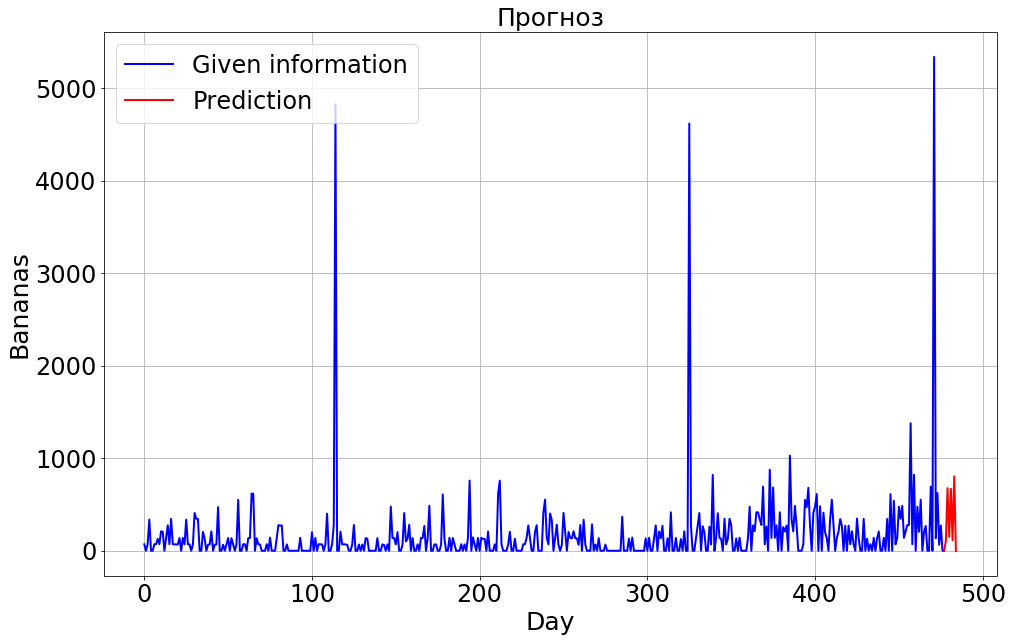

In [13]:
n = np.arange(len(series))
plt.figure(figsize=(16,10))
plt.plot(pred[:series.shape[0]], color="blue", label='Given information')
plt.plot(range(series.shape[0] - 1, len(pred)),pred[series.shape[0] - 1:], color="red", label='Prediction')
plt.xlabel('Day', fontsize=25)
plt.legend(loc='upper left')
plt.ylabel('Bananas', fontsize=25)
plt.title ('Прогноз', fontsize=25)
plt.grid()
plt.show()

## Оценим точность модели на известных данных 
Делим известные данные в отношении $80 \div 20$, строим модель по известным $80\%$, оцениваем ее работу на тесте по метрике $SSE$.

In [14]:
train_size = int(0.8*len(series))
test_size = len(series) - train_size
time = 50
X, U, s, X_ = decom(series[:train_size],time)

In [15]:
train_err = []
for number in range(1, time + 1): # берем разное количество собственных значений
    approx = henkelization(sum([X_[i] for i in range(number)]))# восстанавливаем train по number векторам
    train_err = np.append(train_err, (np.cumsum((series[:train_size] - approx) ** 2))[-1:].values)

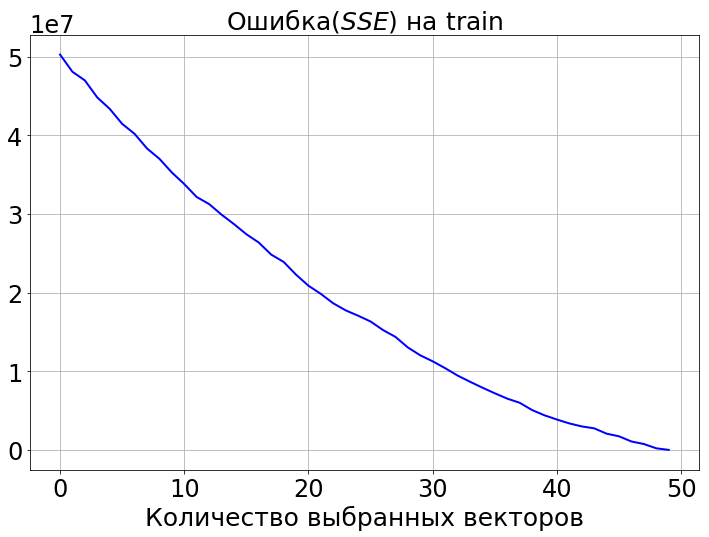

In [22]:
n = np.arange(len(train_err))
plt.figure(figsize=(12,8))
plt.plot(n,train_err, color="blue", label='Given information')
plt.xlabel('Количество выбранных векторов', fontsize=25)
plt.title ('Ошибка($SSE$) на train', fontsize=25)
plt.grid()
plt.show()

Найдем зависимость ошибки от совокупности двух параметров: ширины окна и количества векторов в аппроксимации.

In [20]:
train_size = int(0.8*len(series))
test_size = len(series) - train_size
time = 50

In [21]:
x_er = []# ширина окна
y_er = []# количество векторов в аппроксимации
z_er = []# суммарная MSE ошибка
for i in range(2,50):
    X, U, s, X_ = decom(series,i)
    for j in range(1,i-1):
        approx = henkelization(sum([X_[l] for l in range(j)]))
        z_er += [(np.cumsum((series[:train_size] - approx[:train_size]) ** 2))[-1:].values[0]]
        x_er += [i]
        y_er += [j]

In [106]:
budget_set = go.Scatter3d(x=x_er, y=y_er, z=z_er, opacity = 0.9, 
                            marker=dict(
                                size=2,
                                color='blue',
                                
                            ), 
                            line=dict(
                                width=2,
                                color='rgb(255, 255, 255)'
                            ))
data = [budget_set]
layout1 = go.Layout(
    scene = dict(
    xaxis=dict(
        title='Размер "окна"',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='black'
        )
    ),
    zaxis=dict(
        title='Погрешность',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='black'
        )
    ),
    yaxis=dict(
        title='Количество использованных векторов',
        titlefont=dict(
            family='Arial, sans-serif',
            size=18,
            color='black'
        )
    ),
    ),
    title='Зависимость погрешности на train в зависимости от длины окна и количества используемых векторов',
    autosize=True,
    width=900,
    height=900,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)

fig = go.Figure(data=data, layout=layout1)
plotly.offline.iplot(fig)

In [1]:
### график возможно не отображается в github
### https://nbviewer.jupyter.org/github/burnyshev/StartCode/blob/master/Burnyshev2019Problem20/main.ipynb

Оценим зависимость ошибки от количества векторов выбранных векторов при предсказании данных, не использованных при обучении.

In [103]:
test_err = []
for number in range(1, time + 1): # берем разное количество собственных значений
    predi = prediction(series[:train_size], X, number = number,duracity = test_size,U = U,s = s)
    test_err = np.append(test_err, (np.cumsum((series[train_size:] - predi[train_size:]) ** 2))[-1:].values)

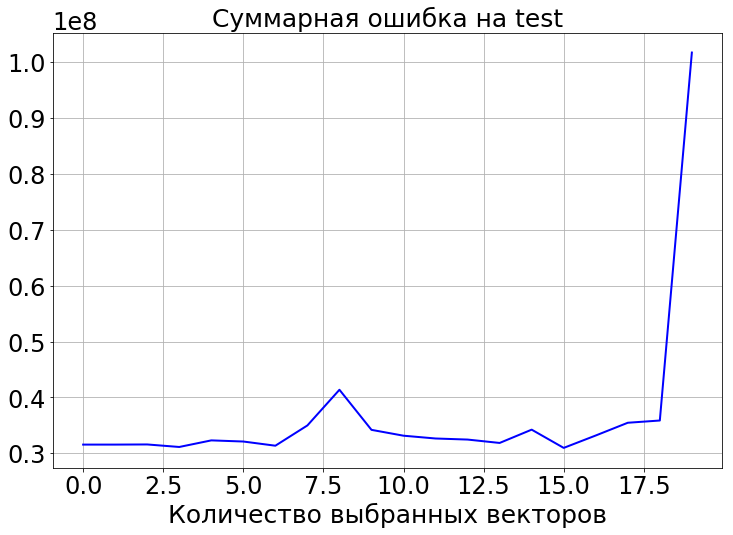

In [104]:
n = np.arange(len(test_err[0:20]))
plt.figure(figsize=(12,8))
plt.plot(n,test_err[0:20], color="blue", label='Given information')
plt.xlabel('Количество выбранных векторов', fontsize=25)
plt.title ('Суммарная ошибка на test', fontsize=25)
plt.grid()
plt.show()

Погрешность резко возрастает при использовании более 18 векторов, происходит переобучение.

## Список литературы:
1. Nina Golyandinaa, Anton Korobeynikov - [Basic Singular Spectrum Analysis and Forecasting with R](https://arxiv.org/pdf/1206.6910.pdf) 
2. Cтатья на [machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=Заглавная_страница) - [Многомерная гусеница, выбор длины и числа компонент гусеницы](http://www.machinelearning.ru/wiki/index.php?title=Многомерная_гусеница%2C_выбор_длины_и_числа_компонент_гусеницы_%28пример%29)
3. Cтатья на [machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=Заглавная_страница) - [Прогнозирование временных рядов методом SSA](http://www.machinelearning.ru/wiki/index.php?title=Прогнозирование_временных_рядов_методом_SSA_%28пример%29)